In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [4]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) ## ?

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

input_shape = (batch_size, 3, 32, 32)
num_labels = 10

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_dataset.shape)

AttributeError: 'CIFAR10' object has no attribute 'shape'

In [4]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, device, expansion_rate=2)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        4,448
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-2              --                        6,528
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─CSC_block: 2-9                    [100, 64, 16, 16]         --
│    │  

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(ASL_VGGNN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_NN(ASL_VGGNN, train_dataloader,
        test_dataloader, epochs=30, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 1.966
test_loss: 1.644, test_accuracy: 38.38
[1,   400] train_loss: 1.633
test_loss: 1.560, test_accuracy: 42.71
[2,   200] train_loss: 1.437
test_loss: 1.298, test_accuracy: 51.07
[2,   400] train_loss: 1.376
test_loss: 1.287, test_accuracy: 52.95
[3,   200] train_loss: 1.253
test_loss: 1.160, test_accuracy: 57.3
[3,   400] train_loss: 1.185
test_loss: 1.085, test_accuracy: 61.9
[4,   200] train_loss: 1.112
test_loss: 0.968, test_accuracy: 65.96
[4,   400] train_loss: 1.063
test_loss: 0.977, test_accuracy: 65.41
[5,   200] train_loss: 1.000
test_loss: 0.929, test_accuracy: 66.54
[5,   400] train_loss: 0.978
test_loss: 0.921, test_accuracy: 68.05
[6,   200] train_loss: 0.925
test_loss: 0.884, test_accuracy: 68.95
[6,   400] train_loss: 0.906
test_loss: 0.884, test_accuracy: 68.87
[7,   200] train_loss: 0.867
test_loss: 0.823, test_accuracy: 70.74
[7,   400] train_loss: 0.868
test_loss: 0.762, test_accuracy: 72.99
[8,   200] train_loss: 0.804
test_loss: 0.797, tes

In [7]:
torch.save(ASL_VGGNN.state_dict(), "./models/Cifar/ASL_VGGNN_exp2.pth")

In [8]:
test_loss = ASL_VGGNN.test_loss
train_loss = ASL_VGGNN.train_loss
test_accuracy = ASL_VGGNN.test_accuracy
train_time = ASL_VGGNN.train_time

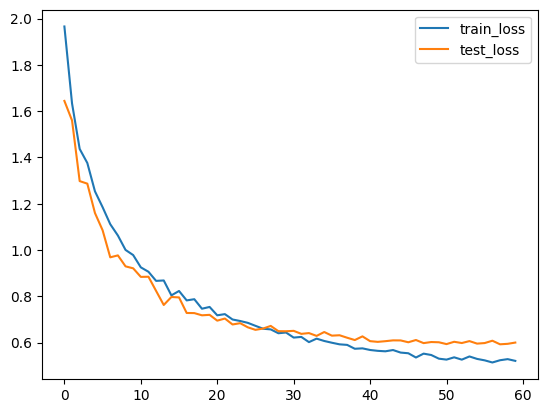

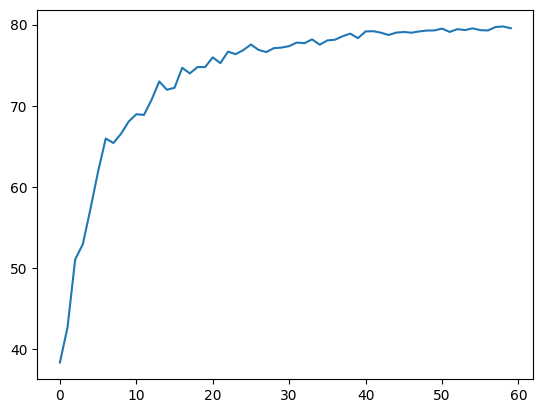

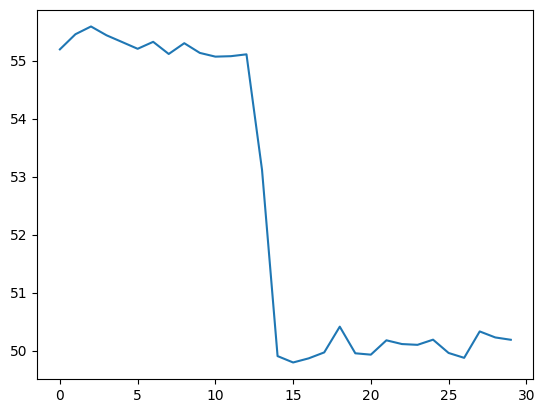

In [9]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(test_accuracy)
plt.show()
plt.plot(train_time)
plt.show()

In [13]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, device, expansion_rate=3)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        6,656
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-2              --                        9,760
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─CSC_block: 2-9                    [100, 64, 16, 16]         --
│    │  

In [14]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(ASL_VGGNN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [15]:
train_NN(ASL_VGGNN, train_dataloader,
        test_dataloader, epochs=30, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 1.932
test_loss: 1.682, test_accuracy: 38.11
[1,   400] train_loss: 1.620
test_loss: 1.460, test_accuracy: 46.14
[2,   200] train_loss: 1.410
test_loss: 1.270, test_accuracy: 53.12
[2,   400] train_loss: 1.330
test_loss: 1.219, test_accuracy: 55.64
[3,   200] train_loss: 1.210
test_loss: 1.064, test_accuracy: 61.28
[3,   400] train_loss: 1.139
test_loss: 1.030, test_accuracy: 62.45
[4,   200] train_loss: 1.066
test_loss: 0.963, test_accuracy: 65.6
[4,   400] train_loss: 1.035
test_loss: 0.978, test_accuracy: 65.28
[5,   200] train_loss: 0.949
test_loss: 0.930, test_accuracy: 66.56
[5,   400] train_loss: 0.952
test_loss: 0.851, test_accuracy: 69.69
[6,   200] train_loss: 0.883
test_loss: 0.815, test_accuracy: 71.35
[6,   400] train_loss: 0.883
test_loss: 0.849, test_accuracy: 70.16
[7,   200] train_loss: 0.838
test_loss: 0.764, test_accuracy: 72.66
[7,   400] train_loss: 0.823
test_loss: 0.812, test_accuracy: 71.26
[8,   200] train_loss: 0.789
test_loss: 0.738, te

In [16]:
torch.save(ASL_VGGNN.state_dict(), "./models/Cifar/ASL_VGGNN_exp3.pth")

In [17]:
test_loss = ASL_VGGNN.test_loss
train_loss = ASL_VGGNN.train_loss
test_accuracy = ASL_VGGNN.test_accuracy
train_time = ASL_VGGNN.train_time

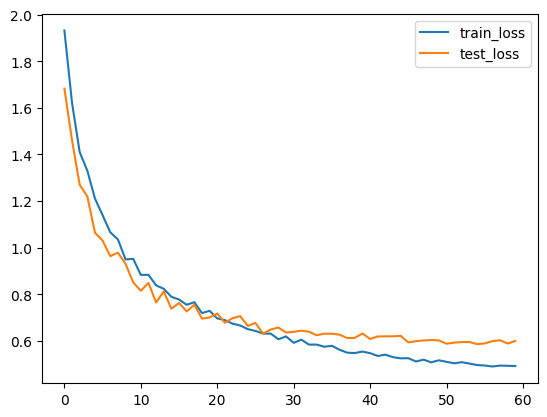

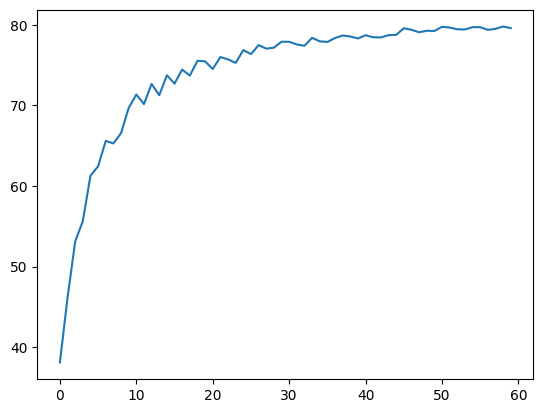

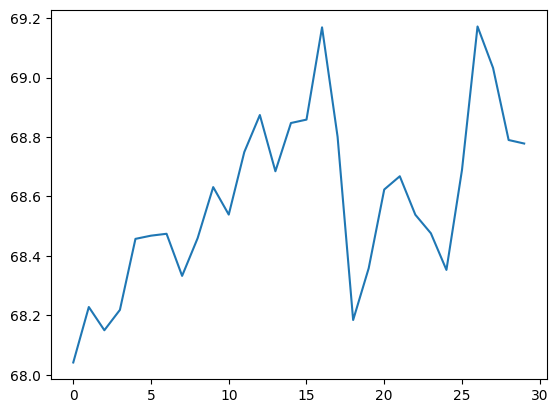

In [18]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(test_accuracy)
plt.show()
plt.plot(train_time)
plt.show()

In [4]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, device)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        2,240
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-2              --                        3,296
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─CSC_block: 2-9                    [100, 64, 16, 16]         --
│    │  

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(ASL_VGGNN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
stats = train_NN(ASL_VGGNN, train_dataloader,
        test_dataloader, epochs=30, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 2.035
test_loss: 1.696, test_accuracy: 36.82
[1,   400] train_loss: 1.679
test_loss: 1.480, test_accuracy: 45.07
[2,   200] train_loss: 1.476
test_loss: 1.366, test_accuracy: 49.25
[2,   400] train_loss: 1.400
test_loss: 1.315, test_accuracy: 52.13
[3,   200] train_loss: 1.279
test_loss: 1.165, test_accuracy: 57.35
[3,   400] train_loss: 1.240
test_loss: 1.099, test_accuracy: 60.09
[4,   200] train_loss: 1.159
test_loss: 1.048, test_accuracy: 61.91
[4,   400] train_loss: 1.145
test_loss: 1.017, test_accuracy: 64.11
[5,   200] train_loss: 1.068
test_loss: 0.983, test_accuracy: 65.51
[5,   400] train_loss: 1.040
test_loss: 0.943, test_accuracy: 66.31
[6,   200] train_loss: 0.998
test_loss: 0.909, test_accuracy: 67.61
[6,   400] train_loss: 0.988
test_loss: 0.887, test_accuracy: 68.59
[7,   200] train_loss: 0.941
test_loss: 0.877, test_accuracy: 69.22
[7,   400] train_loss: 0.935
test_loss: 0.862, test_accuracy: 69.46
[8,   200] train_loss: 0.903
test_loss: 0.849, t

In [11]:
f = open("models/Cifar/ASL_VGGNN.json")
f = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'models/Cifar/ASL_VGGNN.json'

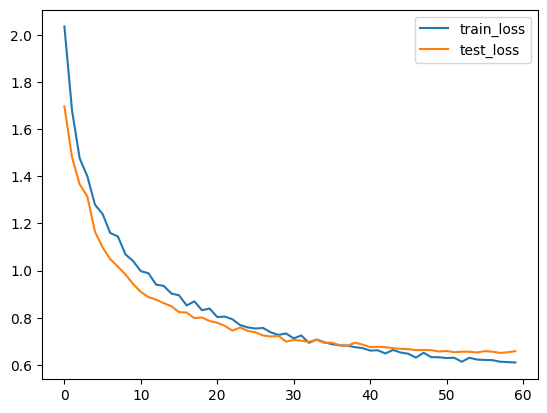

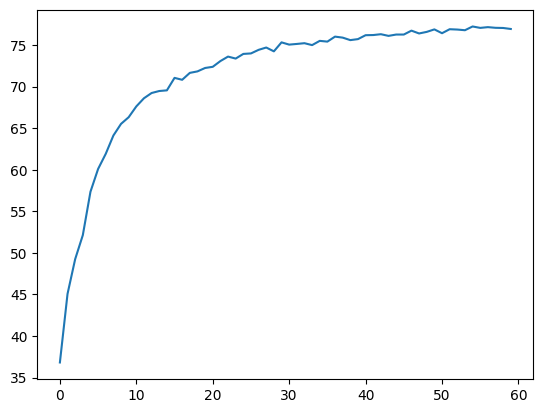

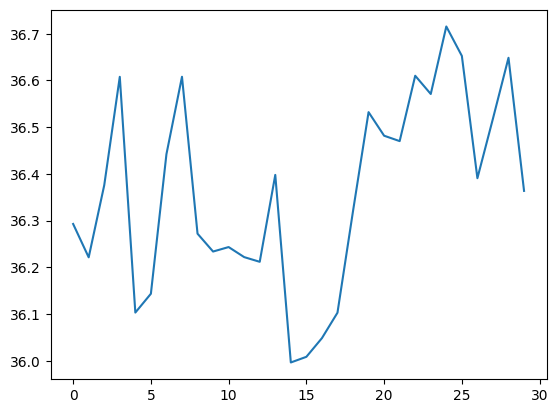

In [7]:
plt.plot(stats[0], label="train_loss")
#plt.show()
plt.plot(stats[1], label="test_loss")
plt.legend()
plt.show()
plt.plot(stats[2])
plt.show()
plt.plot(stats[3])
plt.show()

In [13]:
stats_dict = {"train_loss": stats[0], "test_loss": stats[1], "accuracy": stats[2], "time": stats[3]}

In [28]:
print(ASL_VGGNN.NN[6].NN[3].shifts.detach().to("cpu").numpy())

[[-5.2407610e-01  2.0099774e-01]
 [-4.5876223e-01  7.7441019e-01]
 [ 7.7397984e-01  2.8441721e-01]
 [ 2.2477379e-01  1.5682513e-02]
 [-1.5217930e-01 -9.6889555e-01]
 [-7.4699551e-01 -7.1718341e-01]
 [ 8.4718561e-01 -1.3147959e-01]
 [-1.0866979e+00  3.1804377e-01]
 [ 3.0811888e-01  4.1882977e-01]
 [-4.2845026e-01  6.8214118e-01]
 [ 3.7223351e-01 -1.7447303e-01]
 [-3.9821723e-01  7.8179336e-01]
 [ 2.9148915e-01  6.5435231e-01]
 [ 5.9961982e-02 -5.3529996e-01]
 [ 8.0395633e-01 -4.0435284e-01]
 [ 6.0669124e-01  6.1456287e-01]
 [ 4.0822521e-01  2.9465532e-02]
 [ 2.2952269e-01 -4.0539545e-01]
 [ 9.1135657e-01  6.5852034e-01]
 [-6.8902928e-01 -1.2379069e+00]
 [-6.5551615e-01 -8.1718063e-01]
 [ 7.0992303e-01 -4.5317492e-01]
 [-5.0485116e-01 -4.9343666e-01]
 [ 2.0264463e-01 -9.1153431e-01]
 [-7.9182947e-01 -1.0579211e+00]
 [ 1.9992313e-01  1.9766470e-02]
 [ 6.6075885e-01  7.9805005e-01]
 [ 1.5069362e-04  5.2594483e-01]
 [ 7.8845888e-01 -9.9313033e-01]
 [-4.8207244e-01 -6.1728877e-01]
 [ 1.64055

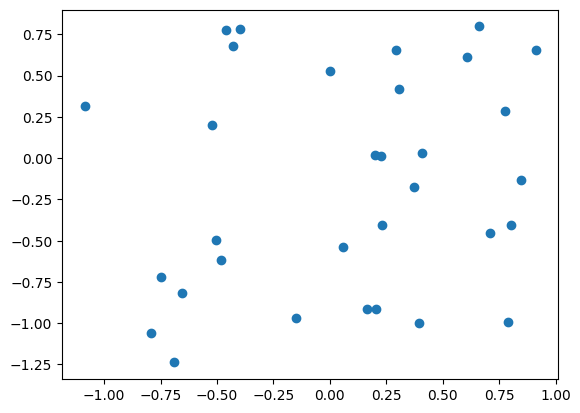

In [34]:
plt.scatter(ASL_VGGNN.NN[6].NN[3].shifts.detach().to("cpu").numpy()[:,0], ASL_VGGNN.NN[6].NN[3].shifts.detach().to("cpu").numpy()[:,1])

# create function

In [ ]:
torch.save(ASL_VGGNN.state_dict(), "./models/Cifar/ASL_VGGNN.pth")

In [ ]:
with open('./models/Cifar/ASL_VGGNN.json', 'w', encoding='utf-8') as f:
    json.dump(stats_dict, f, ensure_ascii=False, indent=4)

In [5]:
from Models import VGGNet

VGGNN = VGGNet(input_shape, num_labels, device)

summary(VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-6                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-7                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-9                         [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-10                   [100, 64, 8, 8]           --
│    └─Conv2d: 2-11                      [100, 128, 8, 8]          73,856

In [6]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(VGGNN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
stats = train_NN(VGGNN, train_dataloader,
        test_dataloader, epochs=20, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 2.303
test_loss: 2.302, test_accuracy: 10.0
[1,   400] train_loss: 2.296
test_loss: 2.233, test_accuracy: 19.89
[2,   200] train_loss: 1.866
test_loss: 1.723, test_accuracy: 35.62
[2,   400] train_loss: 1.676
test_loss: 1.582, test_accuracy: 40.28
[3,   200] train_loss: 1.483
test_loss: 1.431, test_accuracy: 47.31
[3,   400] train_loss: 1.369
test_loss: 1.350, test_accuracy: 50.27
[4,   200] train_loss: 1.207
test_loss: 1.214, test_accuracy: 56.24
[4,   400] train_loss: 1.126
test_loss: 1.089, test_accuracy: 60.68
[5,   200] train_loss: 1.003
test_loss: 1.031, test_accuracy: 63.48
[5,   400] train_loss: 0.972
test_loss: 0.980, test_accuracy: 65.5
[6,   200] train_loss: 0.875
test_loss: 0.905, test_accuracy: 68.56
[6,   400] train_loss: 0.861
test_loss: 0.929, test_accuracy: 67.78
[7,   200] train_loss: 0.778
test_loss: 0.864, test_accuracy: 70.41
[7,   400] train_loss: 0.751
test_loss: 0.820, test_accuracy: 71.95
[8,   200] train_loss: 0.674
test_loss: 0.830, tes

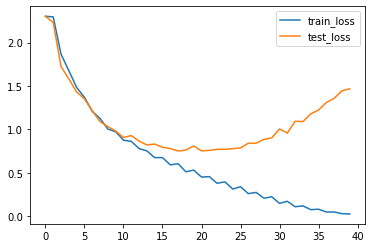

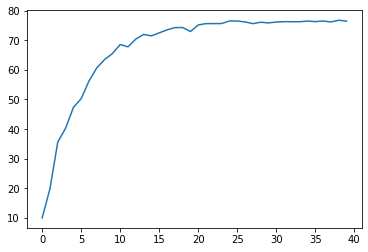

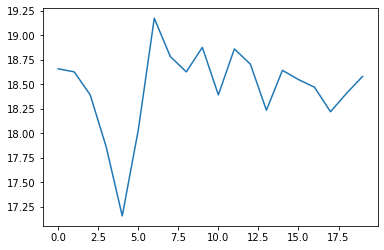

In [7]:
plt.plot(stats[0], label="train_loss")
#plt.show()
plt.plot(stats[1], label="test_loss")
plt.legend()
plt.show()
plt.plot(stats[2])
plt.show()
plt.plot(stats[3])
plt.show()

In [9]:
torch.save(VGGNN.state_dict(), "./models/Cifar/VGGNN_1.pth")

In [11]:
train_error_json = json.dumps(stats[0])
test_error_json = json.dumps(stats[1])
accuracy_json = json.dumps(stats[2])
times_json = json.dumps(stats[3])

stats_dict = {"train_error": train_error_json, "test_error": test_error_json, "accuracy": accuracy_json, "time": times_json}

In [ ]:
with open('./models/Cifar/VGGNN_1.json', 'w', encoding='utf-8') as f:
    json.dump(stats_dict, f, ensure_ascii=False, indent=4)

In [4]:
from Models import VGGNet2

VGGNN2 = VGGNet2(input_shape, num_labels, device)

summary(VGGNN2, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet2                                  [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-7                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-9                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-10                        [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-11                   [100, 64, 8, 8]           --
│  

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(VGGNN2.parameters(), lr=0.01, momentum=0.9)#, weight_decay=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [12]:
stats = train_NN(VGGNN2, train_dataloader,
        test_dataloader, epochs=10, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.547
test_loss: 0.664, test_accuracy: 77.46
[1,   400] train_loss: 0.554
test_loss: 0.665, test_accuracy: 77.5
[2,   200] train_loss: 0.547
test_loss: 0.665, test_accuracy: 77.44
[2,   400] train_loss: 0.544
test_loss: 0.659, test_accuracy: 77.56
[3,   200] train_loss: 0.533
test_loss: 0.661, test_accuracy: 77.42
[3,   400] train_loss: 0.557
test_loss: 0.657, test_accuracy: 77.66
[4,   200] train_loss: 0.537
test_loss: 0.662, test_accuracy: 77.52
[4,   400] train_loss: 0.532
test_loss: 0.658, test_accuracy: 77.53
[5,   200] train_loss: 0.533
test_loss: 0.662, test_accuracy: 77.57
[5,   400] train_loss: 0.541
test_loss: 0.661, test_accuracy: 77.78
[6,   200] train_loss: 0.530
test_loss: 0.656, test_accuracy: 77.55
[6,   400] train_loss: 0.525
test_loss: 0.657, test_accuracy: 77.78
[7,   200] train_loss: 0.529
test_loss: 0.662, test_accuracy: 77.57
[7,   400] train_loss: 0.533
test_loss: 0.658, test_accuracy: 77.78
[8,   200] train_loss: 0.521
test_loss: 0.659, te

In [17]:
f = open("models/Cifar/VGGNN_2.json")
f = json.load(f)


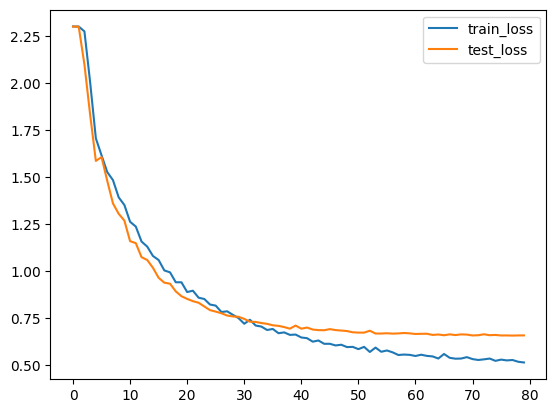

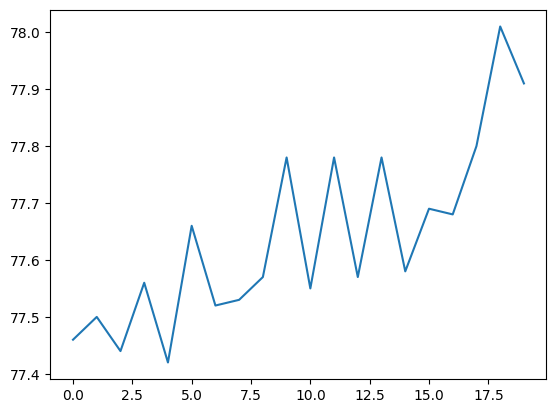

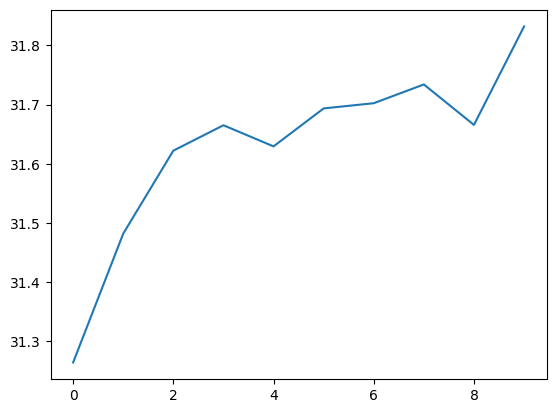

In [19]:
plt.plot(f["train_error"] + stats[0], label="train_loss")
#plt.show()
plt.plot(f["test_error"] + stats[1], label="test_loss")
plt.legend()
plt.show()
plt.plot(stats[2])
plt.show()
plt.plot(stats[3])
plt.show()

In [8]:
torch.save(VGGNN2.state_dict(), "./models/Cifar/VGGNN_2.pth")

In [9]:
# train_error_json = json.dumps(stats[0])
# test_error_json = json.dumps(stats[1])
# accuracy_json = json.dumps(stats[2])
# times_json = json.dumps(stats[3])

stats_dict = {"train_error": stats[0], "test_error": stats[1], "accuracy": stats[2], "time": stats[3]}

In [10]:
with open('./models/Cifar/VGGNN_2.json', 'w', encoding='utf-8') as f:
    json.dump(stats_dict, f, ensure_ascii=False, indent=4)

In [11]:
test_loss(VGGNN2, test_dataloader, criterion, device)

(0.6613720685243607, 77.48)

In [4]:
from Models import Cifar10_Conv_Net

Cifar10_Conv_NN = Cifar10_Conv_Net(input_shape, num_labels, device=device)

summary(Cifar10_Conv_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_Conv_Net                         [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Conv2d: 2-9                       [100, 32, 8, 8]           4,640
│    └─BatchNorm2d: 2-10                 [100, 32, 8, 8]           64
│    └─Tanh: 2-11                        [100, 32, 8, 8]           --
│    └─F

In [6]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(Cifar10_Conv_NN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [11]:
leDepthStats = train_NN(Cifar10_Conv_NN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.777
test_loss: 1.125, test_accuracy: 61.79
[1,   400] train_loss: 0.782
test_loss: 1.126, test_accuracy: 61.79
[2,   200] train_loss: 0.775
test_loss: 1.126, test_accuracy: 61.85
[2,   400] train_loss: 0.777
test_loss: 1.127, test_accuracy: 61.96
[3,   200] train_loss: 0.772
test_loss: 1.127, test_accuracy: 61.85
[3,   400] train_loss: 0.778
test_loss: 1.127, test_accuracy: 61.9
[4,   200] train_loss: 0.768
test_loss: 1.127, test_accuracy: 61.91
[4,   400] train_loss: 0.771
test_loss: 1.127, test_accuracy: 61.83


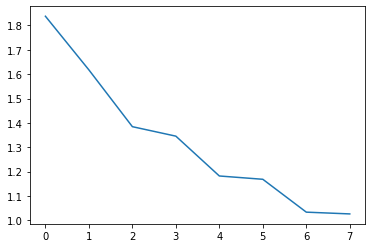

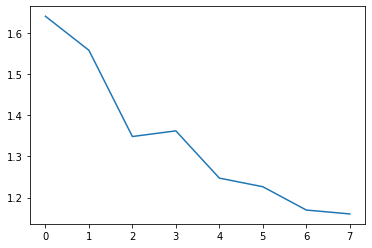

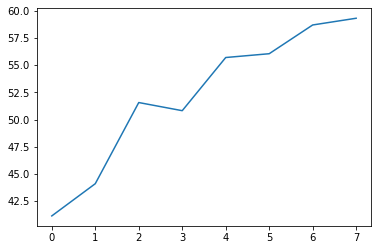

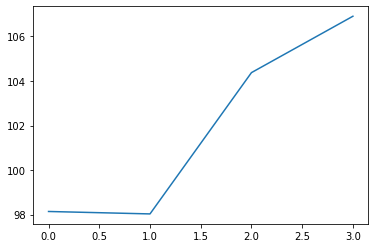

In [9]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()

In [8]:
torch.save(Cifar10_Conv_NN.state_dict(), "./models/Cifar/Cifar10_Conv_NN.pth")

In [20]:
from Models import Cifar10_ASL_Net

expansion_rate = 3

Cifar10_ASL_NN = Cifar10_ASL_Net(input_shape, num_labels, expansion_rate, device)

summary(Cifar10_ASL_NN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_ASL_Net                          [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        502
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─CSC_block: 2-8                    [100, 32, 8, 8]           --
│    │    └─Sequential: 3-2              --                        2,576
│    └─Tanh: 2-9                         [100, 32, 8, 8]           --
│    └─Fla

In [21]:
criterion = CrossEntropyLoss()
Cifar10_ASL_NN_optimizer = optim.SGD(Cifar10_ASL_NN.parameters(), lr=0.1, momentum=0.9)
scheduler_Cifar = optim.lr_scheduler.ExponentialLR(Cifar10_ASL_NN_optimizer, gamma=0.8)

In [23]:
leASLStats = train_NN(Cifar10_ASL_NN, train_dataloader,
        test_dataloader, epochs=6, optimizer=Cifar10_ASL_NN_optimizer, criterion=criterion,
        scheduler=scheduler_Cifar, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.707
test_loss: 1.035, test_accuracy: 64.55
[1,   400] train_loss: 0.715
test_loss: 1.038, test_accuracy: 64.73
[2,   200] train_loss: 0.687
test_loss: 1.037, test_accuracy: 65.08
[2,   400] train_loss: 0.683
test_loss: 1.037, test_accuracy: 65.0
[3,   200] train_loss: 0.681
test_loss: 1.037, test_accuracy: 65.11
[3,   400] train_loss: 0.666
test_loss: 1.038, test_accuracy: 65.04
[4,   200] train_loss: 0.672
test_loss: 1.038, test_accuracy: 65.02


KeyboardInterrupt: 

In [ ]:
torch.save(Cifar10_ASL_Net.state_dict(), "./models/Cifar/Cifar10_ALS_NN.pth")

In [6]:
PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN_cif.load_state_dict(torch.load(PATH))
    NN_cif.eval()

In [9]:
%%timeit
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Cifar.zero_grad()

        # forward + backward + optimize
        outputs = NN_cif(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_Cifar.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_cif, test_dataloader, criterion, device))

    scheduler_Cifar.step()

[1,   244] train_loss: 4.071
(1.4727221763134002, 47.23)


In [10]:
torch.save(NN_cif.state_dict(), "./models/Cifar/Cifar10.pth")

In [8]:
from Models import Cifar10_Net

criterion = CrossEntropyLoss()


input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN2_cif = Cifar10_Net(input_shape, num_labels, expansion_rate)


PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN2_cif.load_state_dict(torch.load(PATH))
    NN2_cif.eval()

print(test_loss(NN2_cif, test_dataloader, criterion))

(1.413678903579712, 49.93)
